# Partial credit documentation

This notebook provides documentation and examples for implementing partial credit in autograder test cells using nbgrader. It uses the [matplotcheck](https://github.com/earthlab/matplotcheck) library for testing plots. 

## Partial credit logic

For a cell to return partial credit with nbgrader, the output of an autograder test cell (i.e. what shows up as `[Out]`, _not_ standard output) must be a number between 0 and the number of points allocated to the cell. The logic for assigning credit is as follows:

1. If the cell returns any errors, credit = 0 (this is the longstanding nbgrader behaviour)
1. If the cell returns a single value that can be cast to a float, x, where 0<= x <= max_points, then credit = x
1. If anything else, credit = max_points

_Key point_: your autograde test cell cannot throw an error if you want to allow partial credit. You must handle any errors within the cell using `try / except` blocks. 

## Setup
Following few cells set up the imports and create a plot. This is the same setup as the `ea-homework-for-timeseries-raster` notebook. 

In [5]:
# Add the required packages needed to run your code here
# We normally check to see if these on in the correct order following PEP guidelines (most common first)
# BEGIN SOLUTION
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import earthpy as et
import hydrofunctions as hf
import urllib

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# prettier plotting with seaborn
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# END SOLUTION

import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
import matplotcheck.raster as ra

In [6]:
# Get data
data = et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

## Test cell

The following cell contains the code we expect the student to generated (an `autograded answer` cell).

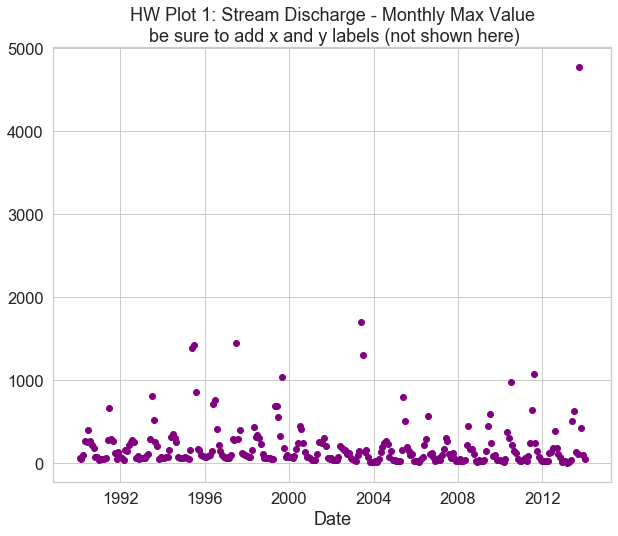

In [7]:
# Create plot

# BEGIN SOLUTION

# import file
f = "data/colorado-flood/discharge/06730200-discharge-daily-1986-2013.txt"
discharge = pd.read_csv(f,
                        skiprows=23,
                        header=[1, 2],
                        sep='\t',
                        parse_dates=[2])
# drop one level of index
discharge.columns = discharge.columns.droplevel(1)
# set the date column as the index
discharge = discharge.set_index(["datetime"])

monthly_max_all = discharge.resample("M").max()
monthly_max = monthly_max_all['1990':'2014']

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=monthly_max.index,
           y=monthly_max["17663_00060_00003"],
           color="purple")
ax.set_title(
    "HW Plot 1: Stream Discharge - Monthly Max Value\n be sure to add x and y labels (not shown here)")

ax.set(xlabel="Date")

# I believe we aren't supposed to use plt.show()
#plt.show()

# END SOLUTION

### DO NOT REMOVE LINE BELOW ###
ts_1_plot = nb.convert_axes(plt)

## Partial credit examples

Now that we have an answer cell, we can show some ways to implement partial credit. The simplest implementation is a series of tests in try / except blocks containing assert statements.

In [11]:
score = 0
hw_plot1 = ts.TimeSeriesTester(ts_1_plot)

# passing test
try:
    hw_plot1.assert_plot_type("scatter")
except:
    pass
else:
    score += 1

# passing test
try:
    hw_plot1.assert_title_contains(["Stream discharge"])
except:
    pass
else:
    score += 2

# failing test; note that the cell does not throw the error, simply handles it with `pass`
try:
    hw_plot1.assert_axis_label_contains(axis="x", lst=["Time"])
except:
    pass
else:
    score += 1
    
score

3

**Adding feedback**

If we want to provide some helpful feedback to students, we can use stdout (i.e. print statements).

In [15]:
score = 0
try:
    hw_plot1.assert_plot_type("line")
except:
    print("Failed test: Your plot is not a scatter plot!")
    pass
else:
    print("Passed test: Your plot is a scatter plot (1 point)")
    score += 1

try:
    hw_plot1.assert_axis_label_contains(axis="x", lst=["Date"])
except:
    print("Failed test: Your x axis label does not contain 'Date'")
    pass
else:
    print("Passed test: Your x axis label contains 'Date' (1 point)")
    score += 1

score

Failed test: Your plot is not a scatter plot!
Passed test: Your x axis label contains 'Date' (1 point)


1

**Simple wrapper, printing errors**

We could wrap the tests into a function that returns the total points, and then simply run the function (all error handling within function). This also shows how to return the error message from the Exception. 

In [34]:
def run_tests(plot):
    total_points = 0

    try:
        hw_plot1.assert_xticks_reformatted(
            tick_size="large", loc_exp="year", m="Please fix this")
        total_points += 1
        print("Pass! x ticks look good! (1 point)")
    except AssertionError as err:
        print("Fail! x ticks have not been reformatted properly")
        print("Error message from exception: {}".format(err))

    try:
        hw_plot1.assert_axis_label_contains(axis="x", lst=["Time"])
        total_points += 1
        print("Pass! X axis label is good!")
    except AssertionError as err:
        print("Fail! x axis label does not contain 'Date'")
        print(" Error message from exception: '{}'".format(err))

    return total_points
    
hw_plot1 = ts.TimeSeriesTester(ts_1_plot)
run_tests(hw_plot1)

    

Pass! x ticks look good! (1 point)
Fail! x axis label does not contain 'Date'
 Error message from exception: 'x axis label does not contain expected text:date'


1